# Deer Detector

Chester Enright

### Summary


We used google_images_download to retrieve files off Google Images for training.  We installed the chromedriver.exe on E:\, so we could download more than 100 per time.

From there, we trained the data to learn whether an image was of a deer or of a forest (which would be our default state).  Eventually, we will need more forest images to train the model better.  We're using resnext50 pretrained as the images are fairly similar to ImageNet

## Download images for training

In [3]:
from google_images_download import google_images_download as gi

In [4]:
response = gi.googleimagesdownload()

In [7]:
## Pass in the various arguments here - note they will be downloaded to download folder 
# they will need to be moved to the proper training spots

arguments = {
    "keywords" : "black and white forest photography", 
    
    # We used a variety of searches, including trail cams, buck, doe, etc.
    # For the validation set, we brought in trail cam thieves, trail cam wolf, trail cam cat, etc. as well
    # as the normal forest photos
    
    "limit" : 100, 
    "print_urls" : False, 
    "chromedriver" : "E:\\chromedriver.exe"
} 

In [ ]:
paths = response.download(arguments)
# Clear this output before printing

## Start Up

In [9]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import numpy as np

sz=400               # Image size to train on - default 299
arch=resnext50       # Architecture to use
bs=10                # Batch size - default 20

# I am actually sacrificing batch size here so I can train on my hardware 
# I think I need larger image size training to detect some of the more subtle features of the deer


In [11]:
# Data path

PATH = "data/deer/"
import os
os.listdir(PATH)


['downloads', 'models', 'ponderosa', 'tmp', 'train', 'valid']

----------------------------------------------------------------------
#### Number of images in the training set for forest and deer
Important to note: Since we have fewer copies of forest, we've just duplicated it 3 times

In [12]:
# Information on training
len(os.listdir(PATH + "train/deer"))


1160

In [13]:
len(os.listdir(PATH + "train/forest"))

1036

--------------------------------------------------
#### Number of images in the validation set for both forest and deer
Important to note: Since we have fewer copies of forest, we've just duplicated it 3 times

##### Update: Seems like it's a pretty bad idea to duplicate your validation data - causes havoc on your accuracy

In [14]:
len(os.listdir(PATH + "valid/forest"))

50

In [15]:
len(os.listdir(PATH + "valid/deer"))

255

## Modelling

In [18]:
# Time to build the model - first used pretrained
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

C:\Users\amunchet\Anaconda3\lib\site-packages\fastai\initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
C:\Users\amunchet\Anaconda3\lib\site-packages\fastai\initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


100%|██████████| 31/31 [00:07<00:00,  4.09it/s]


In [19]:
learn.fit(1e-2, 1)
# Turn of the pretrained, so we can teach deeper
learn.precompute=False

epoch      trn_loss   val_loss   accuracy                    
    0      0.138455   0.100249   0.970492  



In [20]:
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.121061   0.09561    0.967213  
    1      0.102609   0.111266   0.967213                     



[0.11126595478672839, 0.9672131206168503]

In [21]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [22]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.152184   0.146905   0.947541  
    1      0.092172   0.112025   0.967213                     
    2      0.095164   0.126033   0.960656                     



[0.1260326474448895, 0.9606557400500189]

In [23]:
learn.save('deer-duplicated-forest-blackandwhiteaddition')

In [1]:
learn.load('deer-duplicated-forest-blackandwhiteaddition')


NameError: name 'learn' is not defined

In [25]:
os.listdir("data/deer/models")


['deer-600.h5',
 'deer-duplicated-forest-blackandwhiteaddition.h5',
 'deer-duplicated-forest.h5',
 'deer.h5']

In [26]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy_np(probs,y)

0.9606557377049181

## Analyzing results

In [27]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[252   3]
 [  9  41]]


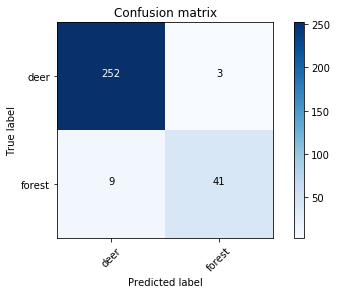

In [28]:
plot_confusion_matrix(cm, data.classes)

In [29]:
titles = []
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])


def load_img_id(ds, idx): 
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [(probs[x],data.val_ds.fnames[x]) for x in idxs]
    titles.append(title_probs)
    print(title)
    return plots(imgs, rows=2, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:10]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

-------------------------

### Wrongly perceived as not a deer 
The model thought it was not a deer, when it actually was.

Perceived as Not deer


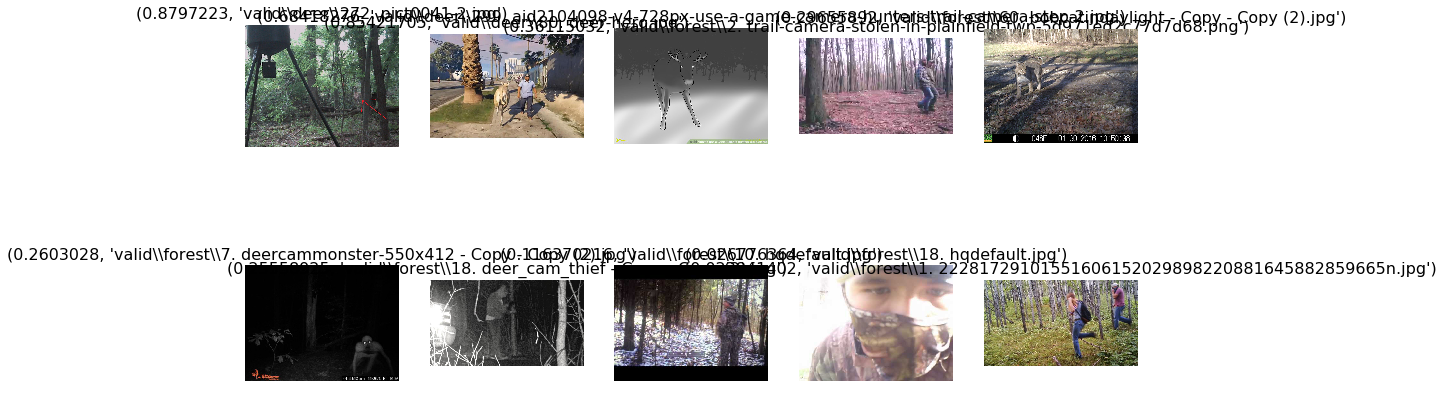

In [30]:
titles = []
plot_val_with_title(most_by_correct(0, False), "Perceived as Not deer")

In [68]:
for it in titles[0]:
    if(it[0] > 0.5):
        print (it[1])
    

valid\deer\299. aid2104098-v4-728px-use-a-game-camera-hunters-trail-camera-step-2.jpg


------------
### Wrongly perceived deer 
Model thought it was a deer, and it was not

Wrongly perceived deer 


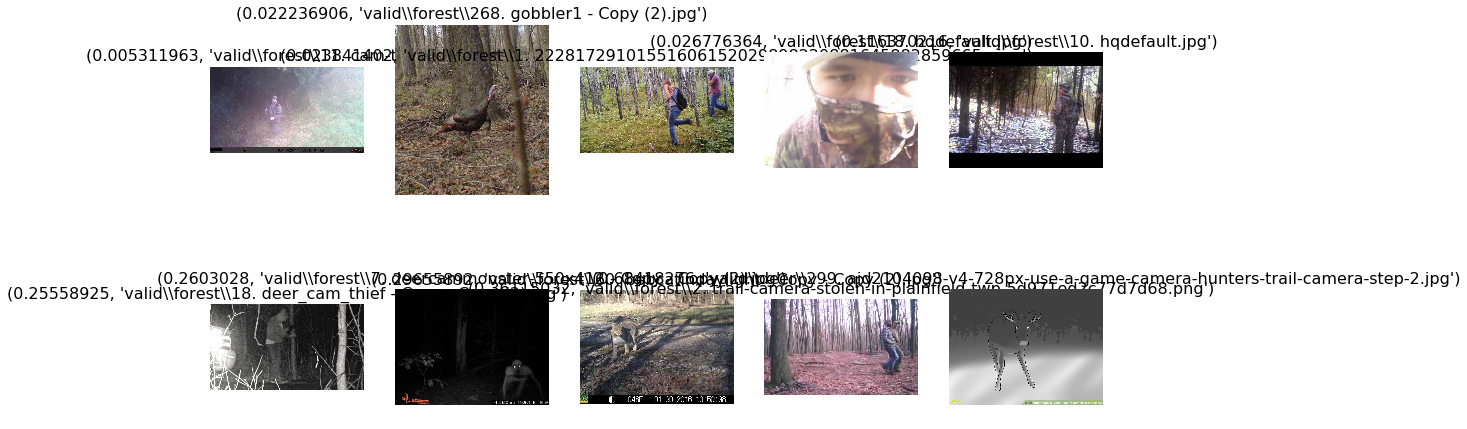

In [32]:
titles = []
plot_val_with_title(most_by_correct(1, False), "Wrongly perceived deer ")

In [67]:
for item in titles:
    for it in item:
        if(it[0] < 0.5):
            print (it[1])

valid\forest\11. cam-thief-lg.jpg
valid\forest\268. gobbler1 - Copy (2).jpg
valid\forest\1. 22281729101551606152029898220881645882859665n.jpg
valid\forest\18. hqdefault.jpg
valid\forest\10. hqdefault.jpg
valid\forest\18. deer_cam_thief - Copy - Copy (2).jpg
valid\forest\7. deercammonster-550x412 - Copy - Copy (2).jpg
valid\forest\60. bobcatindaylight - Copy - Copy (2).jpg
valid\forest\2. trail-camera-stolen-in-plainfield-twp-5d971ed2c77d7d68.png


We tried to put some harder images in validation, and the model struggled with perceiving  a camo human vs deer.

## Individual prediction from Ponderosa photos
We want to make sure that the actual photos from the Ponderosa can be used by the model, otherwise there's no point in doing this.

In [50]:
PATH2 = "data/deer/ponderosa/"
PATH2
fn = "1.jpg"

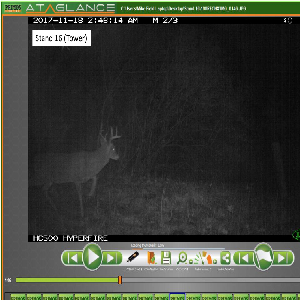

In [51]:
Image.open(PATH2 + fn).resize((300, 300))

#### We have some photos of decidedly not deer to make sure our classifier is behaving

In [52]:
fn = "18.jpg"

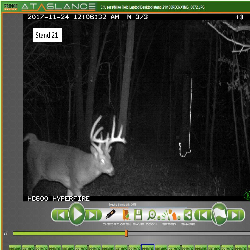

In [53]:
Image.open(PATH2 + fn).resize((250, 250))

In [54]:
fn = "21.jpg"

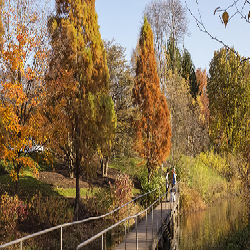

In [55]:
Image.open(PATH2 + fn).resize((250, 250)) # This is the obvious forest photo 
# We want to make sure the model isn't saying everything is deer

In [56]:
num_ponderosa = 21

In [71]:
not_deer_images = []
for i in range(1,num_ponderosa+1):
    fn = str(i) + ".jpg"
    trn_tfms, val_tfms = tfms_from_model(arch, sz)
    im = val_tfms(open_image(PATH2 + fn)) # open_image() returns numpy.ndarray
    preds = learn.predict_array(im[None])
    if(not np.argmax(preds)):
        print(PATH2 + fn + ": Deer!")
    else:
        print (PATH2 + fn + ": Not deer")
        # Image.open(PATH2 + fn).resize((250, 250)))
        not_deer_images.append(PATH2 + fn)
    

data/deer/ponderosa/1.jpg: Deer!
data/deer/ponderosa/2.jpg: Deer!
data/deer/ponderosa/3.jpg: Deer!
data/deer/ponderosa/4.jpg: Deer!
data/deer/ponderosa/5.jpg: Deer!
data/deer/ponderosa/6.jpg: Deer!
data/deer/ponderosa/7.jpg: Deer!
data/deer/ponderosa/8.jpg: Not deer
data/deer/ponderosa/9.jpg: Deer!
data/deer/ponderosa/10.jpg: Deer!
data/deer/ponderosa/11.jpg: Deer!
data/deer/ponderosa/12.jpg: Deer!
data/deer/ponderosa/13.jpg: Deer!
data/deer/ponderosa/14.jpg: Deer!
data/deer/ponderosa/15.jpg: Deer!
data/deer/ponderosa/16.jpg: Deer!
data/deer/ponderosa/17.jpg: Deer!
data/deer/ponderosa/18.jpg: Deer!
data/deer/ponderosa/19.jpg: Deer!
data/deer/ponderosa/20.jpg: Not deer
data/deer/ponderosa/21.jpg: Not deer


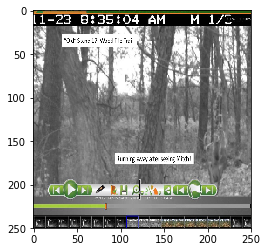

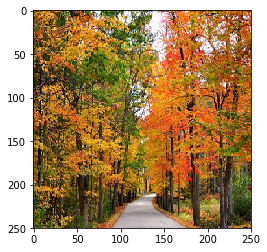

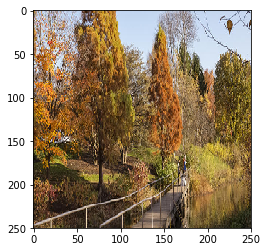

In [72]:
for item in not_deer_images:
    plt.figure()
    plt.imshow(Image.open(str(item)).resize((250,250)))

## Conclusion

8.jpg is fairly hard to see so it's understandable that the model does not detect that.  What I probably want to do is retrain on images from the woods as the forest photos. 